# Evaluating circuit-level performance

# Noise in Gemini-class digital neutral atom quantum processors

QuEra's Gemini-class processors are our first generation of digital quantum computers that take advantage of the unique capabilities of neutral atom qubits. Gemini processors utilize arrays of neutral atoms trapped in optical tweezers, which can be dynamically rearranged to achieve arbitrary qubit connectivity. The native gate set includes single-qubit rotations base on Raman transitions between atomic hyperfine states and two-qubit CZ entangling gates based on the Rydberg blockage interaction, allowing for efficient implementation of quantum algorithms. As a first demonstration of our new hardware, we have recently [published a paper in Nature](https://www.nature.com/articles/s41586-025-09367-3) demonstration magic state distillation in the d=3 and d=5 color codes.

Like any quantum hardware, Gemini-class processors are subject to incoherent and coherent noise processes that cause errors in quantum circuits implemented on the device. To evaluate the practicality of implementing a task on the hardware, noise models at the circuit level can inform algorithm design. To this end, we have developed noise models using the popular circuit SDK [cirq](https://quantumai.google/cirq), which mains interoperability to our internal circuit representation: [squin](https://bloqade.quera.com/latest/digital/cirq_interop/). The quantitative values of these error rates can be found in [bloqade](https://github.com/QuEraComputing/bloqade-circuit/blob/14fdf7aa9f0aa1e2476b230da9a9e7b4dc800231/src/bloqade/qasm2/dialects/noise/model.py#L5) and are described as:

1. Global single qubit gate error
    - Depolarizing error applied to all qubits after a single qubit gate that is applied to all qubits in parallel.
1. Local single qubit gate error
    - Depolarizing error applied to gated single qubits after a single qubit gate that is applied to a subset of qubits.
1. CZ gate error
    - Pauli error channel that is biases towards phase errors applied to both qubits that are within the blockage radius during a Rydberg pulse.
    - Incorporates errors from the Rydberg pulse and dynamical decoupling.
1. Unpaired Rydberg error
    - Pauli error channel is biased towards phase errors applied to single qubits that experience a Rydberg pulse but do not have a partner qubit within the blockade radius.
    - Incorporates errors from the Rydberg pulse and dynamical decoupling.
1. Mover error
    - Pauli error channel that is also biased towards phase errors applied to qubits that must move during a circuit.
    - Incorporates errors from transferring atoms from fixed tweezer traps to dynamical traps for moves, dynamical decoupling, move errors, and idling errors.
1. Sitter error
    - Pauli error channel that is applied to atoms that are stationary while other atoms are moving.
    - Incorporates errors from dynamical decoupling and idling errors.

The error rates are calculated by benchmarking results that will be published in a forthcoming paper characterizing the full performances of our Gemini-class hardware. Particularly relevant to our neutral atom platform is the implementation of atomic moves, required to situate atoms within the Rydberg blockage radius of each other for CZ gates. These atom moves are achieved using dynamic optical tweezers that impose certain [constraints on what moves can be executed concurrently](https://arxiv.org/abs/2506.05536v1). For a general quantum circuit, the optimization of these moves into the fewest possible steps is an active area of research and greatly effects the overall performance of the circuit, because the "sitter error" is significant and thus reducing the total number of moves is critical to achieving high fidelity. In our [circuit noise models in bloqade](https://github.com/QuEraComputing/bloqade-circuit/blob/main/src/bloqade/cirq_utils/noise/model.py), we have taken a middle ground estimate to the number of move steps that are required for a general circuit. For circuits that are amenable to highly parallelized moves when the atom geometry is suitably chosen, our noise models will likely overestimate the total error. However, for worst case circuits that require many move steps for a given circuit layer, our noise models may underestimate the total error. Therefore, a realistic range of performance can be achieved by scaling the mover and sitting error rates.

This notebook describes the effect of the above noise sources in detail to give the user an in-depth intuition into the sources of noise on our Gemini-class machines. Once this knowledge is gained, the example of the implementation of these noise models in preparing a GHZ state is shown in the [bloqade documentation](https://bloqade.quera.com/v0.27.1/digital/examples/noisy_ghz/).

Finally, an important disclaimer is that these noise models exclusively use Pauli channels, modeling incoherent errors. Coherent errors and leakage/loss events are not explicitly accounted for, but rather folded into the effective Pauli error rates. This is a reasonable approximation for many use cases, but may not be valid for all circuits.

# Global vs local single qubit gates

In [3]:
import cirq
import matplotlib.pyplot as plt
import qsimcirq
import numpy as np

from bloqade.cirq_utils.noise import (
    transform_circuit,
    GeminiTwoZoneNoiseModel
)

simulator = qsimcirq.QSimSimulator()

Let's suppose for our first experiment on Gemini we want to test the very basic circuit shown below.

In [4]:
q0, q1 = cirq.LineQubit.range(2)

cirq.Circuit.from_moments(
    cirq.Moment(cirq.X(q0), cirq.Y(q1)),
    cirq.Moment(cirq.Y(q0), cirq.X(q1)),
    cirq.Moment(cirq.X(q0), cirq.Y(q1)),
    cirq.Moment(cirq.Y(q0), cirq.X(q1)),
)

0: ───X───Y───X───Y───

1: ───Y───X───Y───X───

This circuit does not have any two qubit gates, so we don't have to worry any complications due to moves between operations. However, we do have to think carefully about the effects of global vs local single qubit gates. In the above circuit, all of the gates must be applied locally, because the X and Y gates are applied to different qubits in the same moment. However, the errors associated with local single qubit gates are almost an order of magnitude higher, compared to local single qubit gates.

In this case, we can increase the number of gate layers by one to make all the gates global by sliding the gates on qubit 0 back one moment:

In [5]:
cirq.Circuit.from_moments(
    cirq.Moment(cirq.Y(q1)),
    cirq.Moment(cirq.X(q0), cirq.X(q1)),
    cirq.Moment(cirq.Y(q0), cirq.Y(q1)),
    cirq.Moment(cirq.X(q0), cirq.X(q1)),
    cirq.Moment(cirq.Y(q0))
)

0: ───────X───Y───X───Y───

1: ───Y───X───Y───X───────

Let's see how the noise model handles these two circuits.

First, I'll rewrite the `cirq.X` and `cirq.Y` gates in terms of `cirq.PhasedXZGate`s. In most cases, this step is not necessary because the `transform_circuit` function, which adds noise moments to the circuit, will decompose arbitrary single qubit gates into the native gate set. However, this transformer also combines subsequent single qubit gates on the same qubit into a single gate, which would render both circuits above trivial. Therefore, we will manually write the circuits in terms of `cirq.PhasedXZGate`s and set `to_native_gateset=False` in the `transform_circuit` function.

In [6]:
XGATE = cirq.PhasedXZGate(x_exponent = 1,  z_exponent = 0, axis_phase_exponent = 0)
YGATE = cirq.PhasedXZGate(x_exponent = 1,  z_exponent = 0, axis_phase_exponent = 0.5)

In [7]:
def pi_blocks(q0: cirq.Qid, q1: cirq.Qid, n: int, global_gates: bool = True) -> list[cirq.Moment]:
    if global_gates is True:
        return [cirq.Moment(YGATE.on(q1))] + [
            cirq.Moment(XGATE.on_each([q0, q1])),
            cirq.Moment(YGATE.on_each([q0, q1])),
            ] * (n - 1) + [cirq.Moment(XGATE.on_each([q0, q1])),
                           cirq.Moment(YGATE.on(q0))]
    else:
        return [
            cirq.Moment(XGATE.on(q0), YGATE.on(q1)),
            cirq.Moment(YGATE.on(q0), XGATE.on(q1)),
        ] * n

First, let's set `global_gates=False` and inspect the noisy circuit.

In [8]:
local_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, 2,global_gates=False))
print('The clean circuit with local gates:')
print(local_circuit)

The clean circuit with local gates:
0: ───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───

1: ───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────


In [9]:
model = GeminiTwoZoneNoiseModel()
local_circuit_noisy = transform_circuit(local_circuit,to_native_gateset=False, model = model)
print('The noisy circuit with local gates:')
print(local_circuit_noisy)

The noisy circuit with local gates:
0: ───A(0.000806,0.000806,0.00246)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───

1: ───A(0.000806,0.000806,0.00246)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───PhXZ(a=0.5,x=1,z=0)───A(0.00041,0.00041,0.000411)───PhXZ(a=0,x=1,z=0)─────A(0.00041,0.00041,0.000411)───


Let's unpack this noise annotated circuit a bit moment by moment:

1. The error coming from moving the qubits from the storage zone into the entangling zone.
1. The ideally implemented local single qubit gates.
1. The depolarizing error associated with local single qubit gates (note that `px = py = pz`).
1. The the ideal single qubit gates
1. The associated error.

and so on...

Now's let's compare this to the where we slide the top gates back by one moment to make some of the gates global:

In [10]:
global_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, 2,global_gates=True))
print('The clean circuit with global gates:')
print(global_circuit)

The clean circuit with global gates:
0: ─────────────────────────PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───

1: ───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)───PhXZ(a=0.5,x=1,z=0)───PhXZ(a=0,x=1,z=0)─────────────────────────


In [11]:
global_circuit_noisy = transform_circuit(global_circuit,to_native_gateset=False, model = model)
print('The noisy circuit with a global gate:')
print(global_circuit_noisy)

The noisy circuit with a global gate:
0: ───A(0.000307,0.000307,0.000464)──────────────────────────────────────────────────────A(0.000806,0.000806,0.00246)────PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───A(0.000307,0.000307,0.000464)───PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───

1: ───A(0.000806,0.000806,0.00246)────PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───A(0.000307,0.000307,0.000464)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0.5,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───PhXZ(a=0,x=1,z=0)───A(6.5e-05,6.5e-05,6.5e-05)───A(0.000806,0.000806,0.00246)───────────────────────────────────────────────────────


Stepping through this circuit moment by moment:

1. The move error on qubit 1 to go from the storage zone into the entangling zone, qubit 0 gets the sitter error.
1. The ideal local gate on qubit 1.
1. The local single qubit error on qubit1 (github issue opened https://github.com/QuEraComputing/bloqade-circuit/issues/449).
1. The Pauli error channel associated with qubit 0 moving into the entangling zone from the storage zone and qubit 1 sitting while qubit 0 moves.
1. The global X gate on both qubits.
1. The depolarizing error from the global X gate, which is much smaller than the local gate error.
1. The global Y gate on both qubits.
1. The associated depolarizing error.
1. The 2nd global X gate.
1. The associated depolarizing error.
1. The move error to return qubit 1 to the storage zone, qubit 0 sees the sitter error.
1. The local Y gate on qubit 0.
1. THe error associated with the local Y gate on qubit 0.

Now, we can simulate both circuits and even compare the behavior as we increase the number of times the pattern is repeated. Let's choose the following depths:

In [12]:
positions = np.linspace(0.02, 1, 6)[1:] ** 2.5
number_of_blocks = np.unique((positions * 100).astype(int))
print('List of number of blocks to simulate:')
print(number_of_blocks)

List of number of blocks to simulate:
[  2  10  28  57 100]


Now let's simulate the different circuits and compare the probability of measuring the $|0\rangle$ state as a function of depth.

In [13]:
global_state_histograms = {}
local_state_histograms = {}
reps = 1000
for depth in number_of_blocks:
    local_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, depth, global_gates=False))
    global_circuit = cirq.Circuit.from_moments(*pi_blocks(q0, q1, depth, global_gates=True))

    local_circuit_noisy = transform_circuit(local_circuit,to_native_gateset=False, model = model)
    global_circuit_noisy = transform_circuit(global_circuit,to_native_gateset=False, model = model)

    global_results = simulator.run(global_circuit_noisy + cirq.measure([q0, q1], key='m'), repetitions=reps)
    local_results = simulator.run(local_circuit_noisy + cirq.measure([q0, q1], key='m'), repetitions=reps)

    global_state_histograms[depth] = global_results.histogram(key='m')
    local_state_histograms[depth] = local_results.histogram(key='m')


We can plot the probability of measuring the $|00\rangle$ state as a measure of the circuit fidelity.

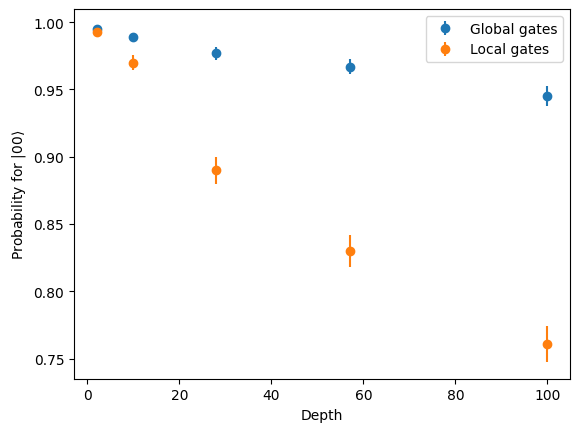

In [14]:
global_00_prob = np.array([hist[0] / reps for hist in global_state_histograms.values()])
local_00_prob = np.array([hist[0] / reps for hist in local_state_histograms.values()])

global_00_err = np.sqrt(global_00_prob * (1 - global_00_prob) / reps)
local_00_err = np.sqrt(local_00_prob * (1 - local_00_prob) / reps)

plt.errorbar(number_of_blocks, global_00_prob, yerr=global_00_err, linestyle='', marker='o', label='Global gates')
plt.errorbar(number_of_blocks, local_00_prob, yerr=local_00_err, linestyle='', marker='o', label='Local gates')

plt.ylabel('Probability for $|00\\rangle$')
plt.xlabel('Depth')

plt.legend()

We can see as the circuit depth increases, the circuit with more global gates outperforms the circuit with all local gates. Accordingly, when structuring quantum circuits for Gemini-class processors, one should always look for opportunities to increase the number of global gates, even at the expense of increasing the circuit depth

# One Zone vs Two Zone Model

Additionally, when going to hardware, there are a couple of options for how to architect the geometry with respect to the entangling zone (ie. the area of the chamber where the Rydberg laser is applied) and the rest of the space accessible by the dynamic tweezers. In the "One Zone" scheme, all the qubits live within the entangling zone for the duration of the experiment. This scheme often can minimize move errors, but all qubits also are exposed to the Rydberg beam, so unpaired errors are significant. In the "Two Zone" scheme, qubits can be shuttled between a storage zone where the Rydberg beam is not applied and the entangling zone. This scheme can minimize unpaired errors, but often requires more moves, which can increase the sitter and mover errors. The choice between these two schemes is often a trade-off that depends on the structure of the circuit.

In our one zone model, we make the assumption that all qubits can move to their entangling partners in a single move step. However, we only need to move one qubit to its gate partner, while the other stays fixed. Then after the gate, the qubit that moved goes back to its original position. This is a rather simplistic assumption, but may work well for certain circuits. We intend to extend this model to account for constraints on parallel moves in the future.

Manim visual?

In our two zone model, we instead make the assumption that if a qubit does not participate in a gate, it should be moved to the storage zone. In some cases, this may result in less total error during the circuit. The model also accounts for moves associated with pairing up qubits within the entangling zone for the CZ gates. Again, this model is rather simplistic and can lead to qubits frequently moving between zones, with deterimental consequences to the total circuit fidelity.

Manim visual?

The implementation of these models is well described in the [bloqade documentation](https://bloqade.quera.com/v0.27.1/digital/examples/noisy_ghz/). The noise models can be imported using:

```
from bloqade.cirq_utils.noise import GeminiOneZoneNoiseModel, GeminiOneZoneNoiseModelConflictGraphMoves, GeminiTwoZoneNoiseModel
```

# Exploring circuit geometry with GridQubits

So, you've written a circuit, benchmarked it using the `GeminiOneZoneNoiseModel` and `GeminiTwoZoneNoiseModel`, and now you're ready to start thinking about the geometry of the atoms in the hardware. Our circuit-level noise modelling tools provide a bridge to the world of move compiliation via the `GeminiOneZoneNoiseModelConflictGraphMoves` noise model. This model uses the same noise parameters as the `GeminiOneZoneNoiseModel`, but also estimates the number of required moves to satisfy the dynamical tweezer constrains using a conflict graph approach. This approach can provide a more realistic estimate of the circuit fidelity and help users optimize the experimental geometry of the qubits in their circuit. We'll take the example of the eight qubit GHZ state prepared in log(N) depth.

In [15]:
def ghz_log_depth_circuit(n_qubits: int) -> cirq.Circuit:
    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()

    # Step 1: Start with a Hadamard on the first qubit
    circuit.append(cirq.H(qubits[0]))

    # Step 2: Apply CNOTs in log-depth tree structure
    targeted = 1
    while targeted < n_qubits:
        moment = cirq.Moment()
        for i in range(0, targeted):
            if targeted+i <n_qubits:
                moment += cirq.CNOT(qubits[i], qubits[targeted+i])
            else:
                break
        targeted += targeted
        circuit += moment

    return circuit

In [16]:
line_qubit_circuit = ghz_log_depth_circuit(8)
print(line_qubit_circuit)

              ┌──┐   ┌────┐
0: ───H───@────@──────@───────
          │    │      │
1: ───────X────┼@─────┼@──────
               ││     ││
2: ────────────X┼─────┼┼@─────
                │     │││
3: ─────────────X─────┼┼┼@────
                      ││││
4: ───────────────────X┼┼┼────
                       │││
5: ────────────────────X┼┼────
                        ││
6: ─────────────────────X┼────
                         │
7: ──────────────────────X────
              └──┘   └────┘


Now, let's map the `cirq.LineQubit`s to `cirq.GridQubit`s to define the geometry. By mapping to different geometries, we will see a different number of total moments in the output circuit, corresponding to some geometries requiring more moves to arrange the atoms without violating the dynamical tweezer constraints.

In [17]:
from bloqade.cirq_utils.noise import GeminiOneZoneNoiseModelConflictGraphMoves

In [18]:
map1 = {
    cirq.LineQubit(0): cirq.GridQubit(0, 0),
    cirq.LineQubit(1): cirq.GridQubit(0, 1),
    cirq.LineQubit(2): cirq.GridQubit(0, 2),
    cirq.LineQubit(3): cirq.GridQubit(1, 0),
    cirq.LineQubit(4): cirq.GridQubit(1, 1),
    cirq.LineQubit(5): cirq.GridQubit(1, 2),
    cirq.LineQubit(6): cirq.GridQubit(2, 0),
    cirq.LineQubit(7): cirq.GridQubit(2, 1),
}

geometry1 = line_qubit_circuit.transform_qubits(lambda q: map1[q])
print(geometry1)

                   ┌──┐   ┌────┐
(0, 0): ───H───@────@──────@───────
               │    │      │
(0, 1): ───────X────┼@─────┼@──────
                    ││     ││
(0, 2): ────────────X┼─────┼┼@─────
                     │     │││
(1, 0): ─────────────X─────┼┼┼@────
                           ││││
(1, 1): ───────────────────X┼┼┼────
                            │││
(1, 2): ────────────────────X┼┼────
                             ││
(2, 0): ─────────────────────X┼────
                              │
(2, 1): ──────────────────────X────
                   └──┘   └────┘


In [19]:
map2 = {
    cirq.LineQubit(0): cirq.GridQubit(0, 0),
    cirq.LineQubit(1): cirq.GridQubit(0, 1),
    cirq.LineQubit(2): cirq.GridQubit(0, 2),
    cirq.LineQubit(3): cirq.GridQubit(0, 3),
    cirq.LineQubit(4): cirq.GridQubit(1, 0),
    cirq.LineQubit(5): cirq.GridQubit(1, 1),
    cirq.LineQubit(6): cirq.GridQubit(1, 2),
    cirq.LineQubit(7): cirq.GridQubit(1, 3),
}

geometry2 = line_qubit_circuit.transform_qubits(lambda q: map2[q])
print(geometry2)

                   ┌──┐   ┌────┐
(0, 0): ───H───@────@──────@───────
               │    │      │
(0, 1): ───────X────┼@─────┼@──────
                    ││     ││
(0, 2): ────────────X┼─────┼┼@─────
                     │     │││
(0, 3): ─────────────X─────┼┼┼@────
                           ││││
(1, 0): ───────────────────X┼┼┼────
                            │││
(1, 1): ────────────────────X┼┼────
                             ││
(1, 2): ─────────────────────X┼────
                              │
(1, 3): ──────────────────────X────
                   └──┘   └────┘


Now let's compare the circuits using these two geometries after passing through the noise model.

In [20]:
model = GeminiOneZoneNoiseModelConflictGraphMoves()
circuit1_noisy = transform_circuit(geometry1, model=model)
print(f'Geometry one required {len(circuit1_noisy)} total moments')

Geometry one required 24 total moments


/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: F

This geometry has some move conflicts, which resulst in a two extra move moments. Add image from Pedro

In [21]:
model = GeminiOneZoneNoiseModelConflictGraphMoves()
circuit2_noisy = transform_circuit(geometry2, model=model)
print(f'Geometry two required {len(circuit2_noisy)} total moments')

Geometry two required 22 total moments


/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: FutureWarning: In cirq 1.6 the default value of `use_repetition_ids` will change to
`use_repetition_ids=False`. To make this warning go away, please pass
explicit `use_repetition_ids`, e.g., to preserve current behavior, use

  CircuitOperations(..., use_repetition_ids=True)
  warnings.warn(msg, FutureWarning)
/Users/tylercochran/Documents/QuEra_repos/bloqade/.venv/lib/python3.10/site-packages/cirq/circuits/circuit_operation.py:173: F

This geometry allows all the moves to be done in parallel, minimizing the total amount of sitter error over the course of the circuit. Add image from Pedro

# Jonathan's original outline:

Canonical circuit we will use for this example: Trotterization of 1d Ising.

In [ ]:
import bloqade
import bloqade.squin
import kirin
from kirin.dialects.ilist import IList


@bloqade.squin.kernel
def bloqade_trotter(qubits: IList, steps: int, dt: float = 0.01, J: float = 1, h: float = 1):
    """
    Main function that runs the Trotter circuit for a given number of steps
    """
    for _ in range(steps):
        zz = bloqade.squin.op.zzpow(dt * J)
        x = bloqade.squin.op.xpow(dt * h)
        for i in range(0, len(qubits) - 1, 2):
            bloqade.squin.op.apply(zz, qubits[i], qubits[i + 1])
        for i in range(1, len(qubits) - 1, 2):
            bloqade.squin.op.apply(zz, qubits[i], qubits[i + 1])
        for i in range(0, len(qubits)):
            bloqade.squin.op.apply(x, qubits[i])


def trotter_builder(nqubits: int,
                    steps: int = 100,
                    dt: float = 0.01,
                    J: float = 1,
                    h: float = 1) -> kirin.ir.Method:
    """
    Builder function to create a Trotter circuit with the specified parameters.

    Inputs:
        nqubits: Number of qubits in the circuit.
        steps: Number of Trotter steps to perform.
        dt: Time step for the Trotter evolution.
        J: Coupling strength for the ZZ interaction.
        h: Strength of the X field.
    Returns:
        A kernel function with no inputs and returns the qubits after the Trotter evolution.
    """

    def main():
        qubits = bloqade.squin.qubit.create(nqubits)
        bloqade_trotter(qubits, steps, dt, J, h)
        return qubits

    # Enforce the CZ + XYphase structure with a compiler pass
    main2 = bloqade.squin.passes.CZGateSet()(main)

    return main2

Now that we have specified the circuit, we can start doing analysis...

Simplest analysis: counting the number of gates and estimating a utility function

## Log fidelity analysis
Count the number of gates; log fidelity is simply a weighted sum/dot product.

In [9]:
# Only works with no mid-circuit feed-forward? Optionally, run statevector evolution
# and sample from the distribution to get a monte carlo estimate of the counting.
noise_interpreter = bloqade.circuit.interpreters.noise_counting()

report = noise_interpreter.run(trotter_builder(10, steps=10, dt=0.01, J=1, h=1))
report.print()
# Number of qubits:        10
# Number of 2 qubit gates: 90
# Number of 1 qubit gates: 100
# Number of touches:       50
# Number of moves:         10

error_model = bloqade.circuit.GeminiErrorModel(scale=0.7)
log_fidelity: float = report.log_fidelity(error_model)
print(f"Log fidelity: {log_fidelity:.3f}")
# Log fidelity: -1.234

AttributeError: module 'bloqade' has no attribute 'circuit'

## Noise annotation in Cirq

Reproduce and reference [cirq_tools](https://github.com/QuEraComputing/cirq_tools/)

### GHZ circuit example

cirq_tools.examples.ghz_with_noise.ipynb

This shows results for the 1 zone model, the 2 zone model, and the model that includes a notion of geometry and AOD constraints.

We can also run the TFIM dynamics through the noise model to stay on theme. tcochran could do this.

## Noise annotation in Bloqade

In [ ]:
raise NotImplementedError("We cannot do noise simulation with bloqade")